In [1]:
import pandas as pd 
import numpy as np 
import re
from tqdm import tqdm 

In [2]:
import torch
import transformers
from transformers import BertForSequenceClassification, XLMRobertaForSequenceClassification, AdamW, BertConfig, BertTokenizer, XLMRobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import re
from bs4 import BeautifulSoup

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/option-generation/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [10]:
'''
Construct object in BERT sentiment classifier class
'''
sentiment_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden states.
)

sentiment_model.to(device) # Puts model on GPU

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [11]:
'''
Load pretrained sentiment model parameters
'''
sentiment_model.load_state_dict(torch.load("../Model/English_sentiment_model.pt", map_location=device), strict=False)

_IncompatibleKeys(missing_keys=['bert.embeddings.position_ids'], unexpected_keys=[])

In [12]:
sentiment_model.eval() # Put model in inference (as opposed to training) mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
'''
Load tokenizer for sentiment model
'''
sentiment_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [14]:
# gets the text into the format we want
def clean_tweet(tweet):
  tweet = BeautifulSoup(tweet, "lxml").get_text() # turns xml-formatted text into regular text
  tweet = re.sub(r"@[A-Za-z0-9]+", " ", tweet) # gets rid of all user references in tweets (i.e. "@username")
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", " ", tweet) # gets rid of URLs
  tweet = re.sub(r"[^A-Za-z.!?áéíóúüñ¿ÁÉÍÓÚÜÑ']", " ", tweet) # gets rid of any non-standard characters in the tweets
  tweet = re.sub(r" +", " ", tweet) # replaces all excess whitespace with a single space

  return tweet # gives us our cleaned tweet

In [15]:
def predict_sentiment(tweet):

    '''
    Predict the sentiment of an input text
    '''
    
    tweet = clean_tweet(tweet)
    tweet_input_id = []
    tweet_attention_mask = []

    tweet_dict = sentiment_tokenizer.encode_plus(
                            tweet,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            truncation=True,           # Explicitly enable truncation
                            padding = 'max_length',
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

    # Add the encoded sentence to the list.    
    tweet_input_id.append(tweet_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    tweet_attention_mask.append(tweet_dict['attention_mask'])

    # Convert the lists into tensors.
    tweet_input_id = torch.cat(tweet_input_id, dim=0)
    tweet_attention_mask = torch.cat(tweet_attention_mask, dim=0)

    tweet_data = TensorDataset(tweet_input_id, tweet_attention_mask)
    
    tweet_dataloader = DataLoader(tweet_data)
    
    for data in tweet_dataloader:
        tweet_input_id = data[0].to(device=device)
        tweet_attention_mask = data[1].to(device=device)
    
    tweet_logits = sentiment_model(tweet_input_id, token_type_ids=None, attention_mask=tweet_attention_mask)
    
    tweet_logits = tweet_logits[0].detach().cpu().numpy()

    tweet_logits = torch.Tensor(tweet_logits)

    softmax = torch.nn.Softmax(dim=1)
    prob_dist = softmax(tweet_logits)

    sentiment_pred = prob_dist.tolist()

    sentiment_pred = sentiment_pred[0][1]

    return sentiment_pred

In [16]:
#Another version of semantic distance here 
from transformers import pipeline 

In [17]:
#sentence level embeddings 
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')
# model.to(device)
#example use 
# sentences = ["Hello World", "Hallo Welt"]
# embeddings = model.encode(sentences)
# print(embeddings)

In [18]:
generations = pd.read_csv('../../Data/Study4/modified_generation_data.csv')

In [19]:
import math 
from scipy import spatial 
# def dist(r1, r2):
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=2)
def dist(r1, r2):
    r1 = np.array(r1)
    r2 = np.array(r2)
    return spatial.distance.cosine(r1, r2)
# def dist(r1, r2):
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=1)

# **Total Semantic Exploration (adjusted) vs Average Sentiment**

In [17]:
#semantic exploration vs average sentiment
exploration = {}
individual_sentiment = {}
for id, group in tqdm(generations.groupby("id")):
  exploration[id] = 0
  individual_sentiment[id] = []
  len_responses = 0
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
        individual_sentiment[id].append(predict_sentiment(response))
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[id] += dist(embeddings[i], embeddings[j])
  exploration[id] /= len_responses

  0%|                                                                                                                                                                               | 0/311 [00:00<?, ?it/s]


RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
#find average sentiment 
for id in individual_sentiment:
  individual_sentiment[id] = sum(individual_sentiment[id])/len(individual_sentiment[id])

In [ ]:
x = []
y = []
for id in exploration:
  # if .7 < individual_sentiment[id] < .9:
    x.append(individual_sentiment[id])
    y.append(exploration[id])

In [ ]:
#display adjusted exploration vs average sentiment 
import seaborn as sns 
import scipy.stats as stats
import matplotlib.pyplot as plt

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Sentiment', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [ ]:
#try to combine the above two plots 
import plotnine
from plotnine import ggplot, aes
# package for plot scales
from mizani.formatters import comma_format # (thousands seperator format)

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Average_Sentiment", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Average_Sentiment', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5) + 
 plotnine.xlab("Average Sentiment") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.coords.coord_cartesian(ylim=(1,2)) +
 plotnine.theme_classic()
).draw()




#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


In [ ]:
def average_embedding(embeddings):
  df = pd.DataFrame(embeddings)
  df = df.mean(axis=0)
  return df.values.tolist()

# **Total Semantic Exploration vs Generation Number**

In [24]:
generations

Unnamed: 0  vignette_name  generation_number  \
0              0              1                  1   
1              1              1                  2   
2              2              1                  3   
3              3              1                  4   
4              4              1                  5   
...          ...            ...                ...   
9315        9315             18                  1   
9316        9316             18                  2   
9317        9317             18                  3   
9318        9318             18                  4   
9319        9319             18                  5   

                                               response  reflection_score   id  
0                         Ask family/friends for money.          0.850000    1  
1                    Try and find it cheaper elsewhere.          0.803333    1  
2                                      Take out a loan.          0.473333    1  
3                                       Pay it anyways.          0.776667    1  
4              Try and haggle with insurance or seller.          0.583333    1  
...                                                 ...               ...  ...  
9315               keep going and ignore the competitor          0.413333  311  
9316                          stop and try to help them          0.890000  311  
9317  find a way to send a message to people that so...          0.830000  311  
9318     stop and also try and get other people to stop          0.576667  311  
9319  let people know at the next check point what w...          0.943333  311  

[9320 rows x 6 columns]

In [ ]:
# Real semantic exploration 
#exploration and answers tally average
exploration = {}
answers = {}
#exp and nums tally the individual explorations
exp = []
nums = []
for id, group in tqdm(generations.groupby("id")):
  for pnum, group2 in group.groupby("generation_number"):
    if pnum not in exploration: 
      exploration[pnum] = []
      # answers[pnum] = 0
    embeddings = []
    for response, group3 in group2.groupby("response"):
      response = group3['response'].to_list()[0]
      if not pd.isna(response):
        embeddings.append(model.encode(response).tolist())
    # answers[pnum] += len(embeddings)
    e = 0
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        e += dist(embeddings[i], embeddings[j])
    exploration[pnum].append(e/len(embeddings))
    exp.append(e/len(embeddings))
    nums.append(pnum)

x_avg = []
y_avg = []
for num in exploration:
  x_avg.append(num)
  y_avg.append(sum(exploration[num])/len(exploration[num]))

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 309/311 [00:49<00:00,  5.63it/s]

In [ ]:
#plotting for stats
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[nums,exp])
d = d.T
d.columns = ["Generation_Number", "Semantic_Exploration"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Semantic_Exploration"]

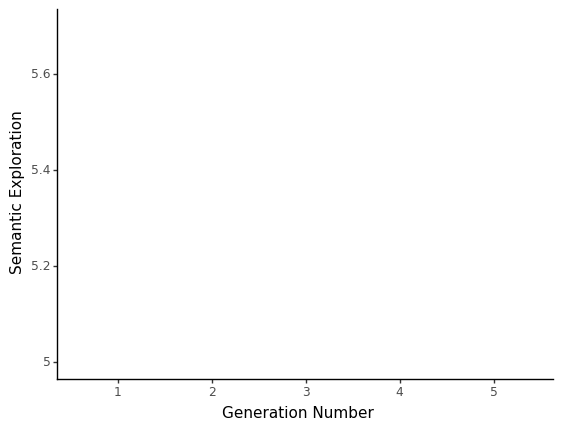

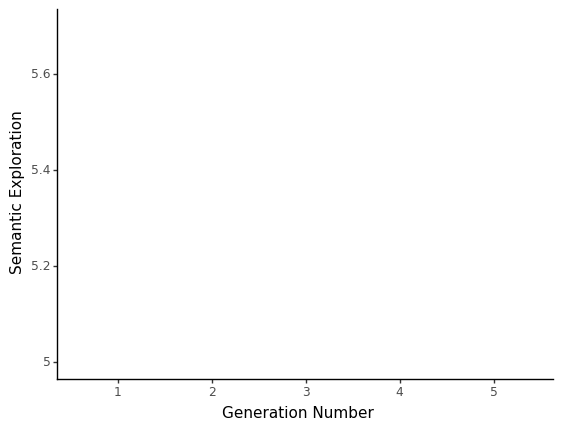

In [ ]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Semantic_Exploration"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Semantic_Exploration-yerr",ymax="Semantic_Exploration+yerr"), color="red",width=.15) + 
 plotnine.ylab("Semantic Exploration") +
 plotnine.xlab("Generation Number") +
  plotnine.coords.coord_cartesian(ylim=(5,5.70)) +
 plotnine.theme_classic()
  ).draw()

In [ ]:
def total_variation(e):
  variation = 0
  count = 0
  for i in range(len(e)):
    for j in range(i+1, len(e)):
      variation += dist(e[i], e[j])
      count += 1
      if count%10000==0:
        print("done")
  return variation

# **Semantic Dissimilarity vs Generation Number**

In [ ]:
# Semantic space similarity vs possibiltiy number (pairwise sim between all avg. embedding vectors)
vectordic = {}
for id, group in generations.groupby("id"):
  for pnum, group2 in group.groupby("generation_number"):
    if pnum not in vectordic:
      vectordic[pnum] = []
    embeddings = []
    for generation in group2['response']:
      if not pd.isna(generation):
        embeddings.append(model.encode(generation))
    embeddings = pd.DataFrame(embeddings)
    embeddings = embeddings.mean(axis=0)
    embeddings = embeddings.values.tolist()
    vectordic.get(pnum).append(embeddings)


In [ ]:
#semantic space dissimilarity vs generation nums
similarity = []
nums = []
avg_dic = {}
for num in vectordic:
  avg_dic[num] = []
  for i in range(len(vectordic.get(num))):
    for j in range(i+1, len(vectordic.get(num))):
      nums.append(num)
      s = dist(vectordic.get(num)[i], vectordic.get(num)[j])
      similarity.append(s)
      avg_dic[num].append(s)


In [ ]:
# remove invalid data - why would the distance between two distinct localizing vectors be 0? 
x = nums
y = similarity
i = 0 
avg_dic = {}
while i < len(x):
  if y[i] == 0:
    y.pop(i)
    x.pop(i)
    i -= 1
  else:
    if x[i] not in avg_dic:
      avg_dic[x[i]] = []
    avg_dic[x[i]].append(y[i])
  i += 1
x_avg = []
y_avg = []
for num in avg_dic:
  avg_dic[num] = sum(avg_dic[num])/len(avg_dic[num])
  x_avg.append(num)
  y_avg.append(avg_dic[num])

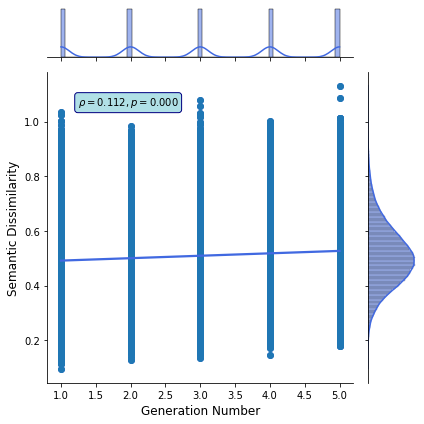

In [ ]:
#plotting to find stats 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

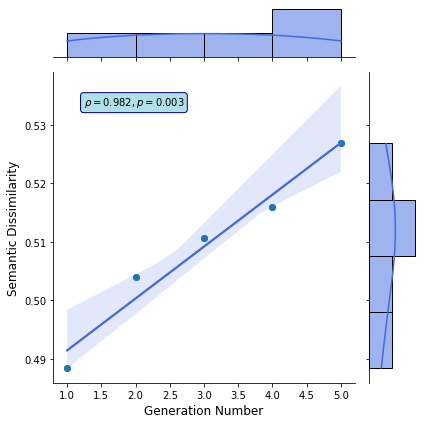

In [ ]:
#plotting to find stats 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Semantic_Dissimilarity"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Semantic_Dissimilarity"]

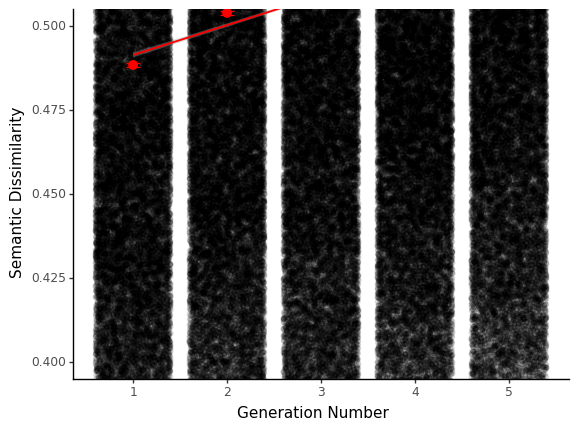

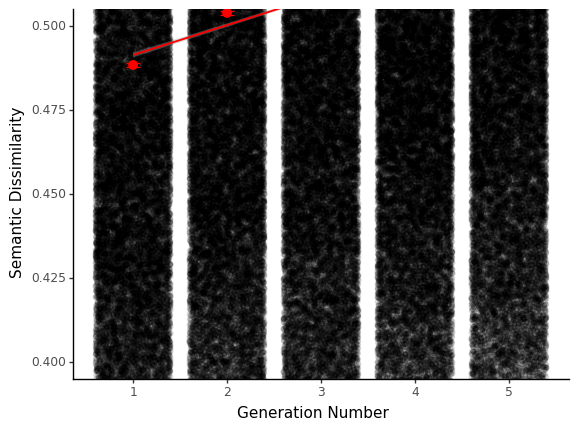

In [ ]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Semantic_Dissimilarity"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Dissimilarity'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.1) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Semantic_Dissimilarity-yerr",ymax="Semantic_Dissimilarity+yerr"), color="red",width=.15) + 
 plotnine.ylab("Semantic Dissimilarity") +
 plotnine.xlab("Generation Number") +
  plotnine.coords.coord_cartesian(ylim=(.4,.5)) +
 plotnine.theme_classic()
  ).draw()

# **Subjective Goodness vs Generation Number**

In [ ]:
#average goodness rating per possibility 
scores = [[] for i in range(5)]
nums = [i for i in range(5)]

#all of the ratings 
s = []
n = []

for pnum, group1 in generations.groupby("generation_number"):
  for score in group1['reflection_score']:
    scores[pnum-1].append(score)
    s.append(score)
    n.append(pnum)

for i in range(len(scores)):
  scores[i] = sum(scores[i])/len(scores[i])

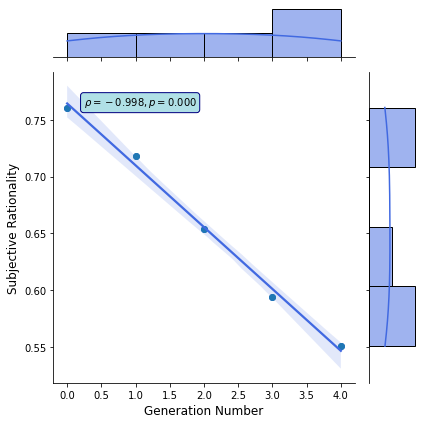

In [ ]:
#plotting for stats
x_avg = np.array(nums) 
y_avg = np.array(scores)

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Subjective Rationality', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[n,s])
d = d.T
d.columns = ["Generation_Number", "Generation_Goodness"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Goodness"]

errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Goodness"]/(len(group["Generation_Goodness"])**.5))
d2["yerr"] = errors


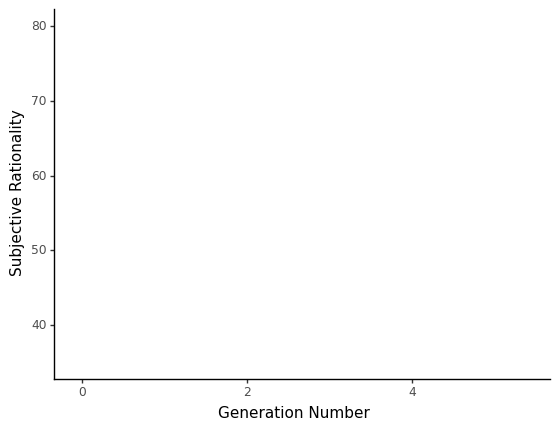

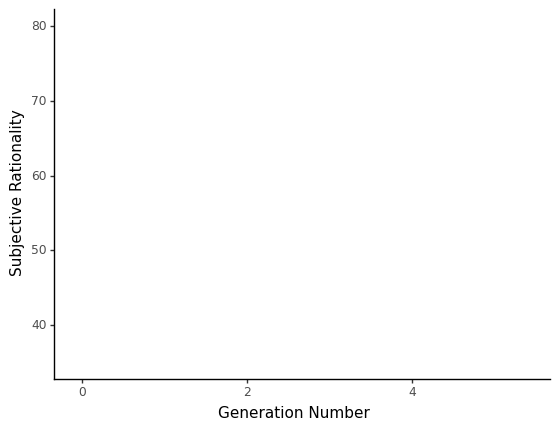

In [ ]:
scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Generation_Goodness'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Goodness-yerr",ymax="Generation_Goodness+yerr"), color="red",width=.15) + 
 plotnine.ylab("Subjective Rationality") +
 plotnine.xlab("Generation Number") + 
 plotnine.theme_classic()  +
 plotnine.coords.coord_cartesian(ylim=(35,80)) 
 ).draw()

# **Generation Sentiment vs Generation Number**

In [ ]:
#generation sentiment vs generation number

sentiment = []
nums = []
avg_sentiment = {}
for id, participant in generations.groupby('id'):
  for pos_num, group in participant.groupby('generation_number'):
    if pos_num not in avg_sentiment:
      avg_sentiment[pos_num] = []
    for generation in group['response']:
      if not pd.isna(generation):
        s = predict_sentiment(generation)
        sentiment.append(s)
        nums.append(pos_num)
        avg_sentiment[pos_num].append(s)

In [ ]:
x = nums
y = sentiment

x_avg = []
y_avg = []
for num in avg_sentiment:
  x_avg.append(num)
  y_avg.append(sum(avg_sentiment[num])/len(avg_sentiment[num]))

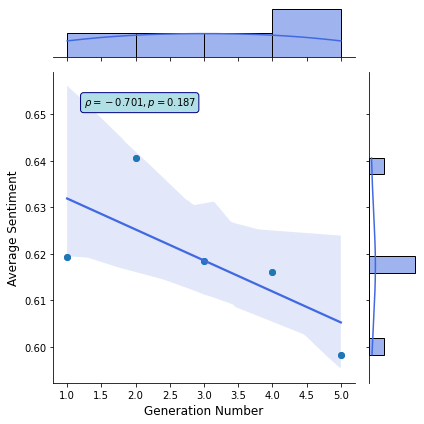

In [ ]:
#plotting for stats 
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Sentiment', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Generation_Sentiment"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Sentiment"]

errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Sentiment"]/(len(group["Generation_Sentiment"])**.5))
d2["yerr"] = errors


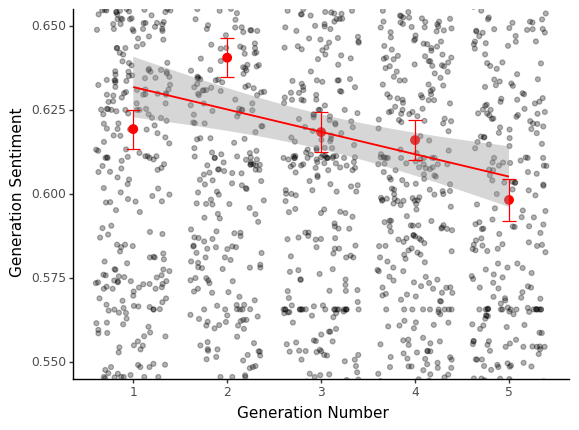

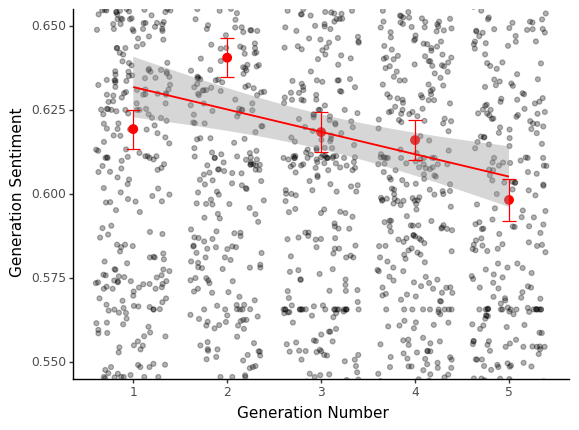

In [ ]:
scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Generation_Sentiment'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Sentiment-yerr",ymax="Generation_Sentiment+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Sentiment") +
 plotnine.xlab("Generation Number") + 
 plotnine.theme_classic() +
 plotnine.coords.coord_cartesian(ylim=(.55,.65)) 
).draw()

# **Generation Concreteness vs Generation Number**

In [ ]:
concreteness = pd.read_csv("https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/Misc/Concreteness_ratings_Brysbaert_et_al_BRM.csv")

In [ ]:
#create concreteness dict
concreteness_dict = {}
for word, group in concreteness.groupby("Word"):
  rating = group["Conc.M"].values[0]
  concreteness_dict[word] = rating

In [ ]:
#figure out if later generations are more or less concrete 
import string 

conc = []
nums = []
cdic = {}
for id, group in generations.groupby("id"):
  for vign, group2 in group.groupby("vignette_name"):
    for num, group3 in group2.groupby("generation_number"):
      for response, group4 in group3.groupby("response"):
        if not pd.isna(response):
          response = response.translate(str.maketrans('', '', string.punctuation))
          score = []
          l = len(response.split(" "))
          for word in response.split(" "):
            if word in concreteness_dict:
              score.append(concreteness_dict[word])
          if len(score) > 0:
            score = sum(score)/len(score)
            # score = (sum(score)/len(score))/l
            conc.append(score)
            nums.append(num)
            if num not in cdic:
              cdic[num] = []
            cdic[num].append(score)

In [ ]:
#find averages in concreteness differences
x_avg = []
y_avg = [] 
for key in cdic:
  cdic[key] = sum(cdic[key])/len(cdic[key])
  x_avg.append(key)
  y_avg.append(cdic[key])

print(cdic)

{1: 2.820578306125866, 2: 2.8073681564187614, 3: 2.7588918892509193, 4: 2.7564898533733513, 5: 2.7676695689918778}


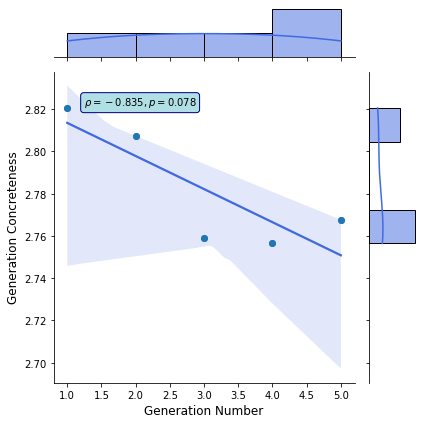

In [ ]:
#just for stats

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Generation Concreteness', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[nums,conc])
d = d.T
d.columns = ["Generation_Number", "Generation_Concreteness"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Concreteness"]

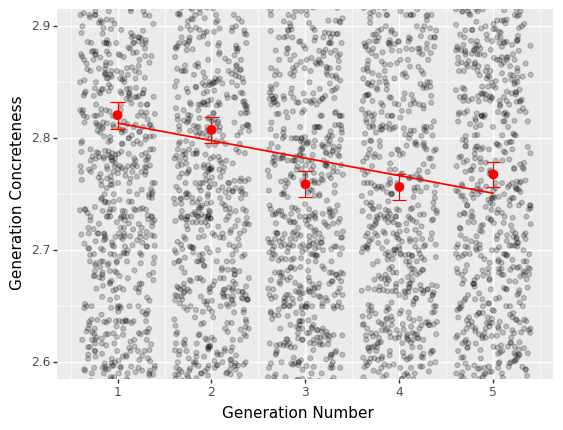

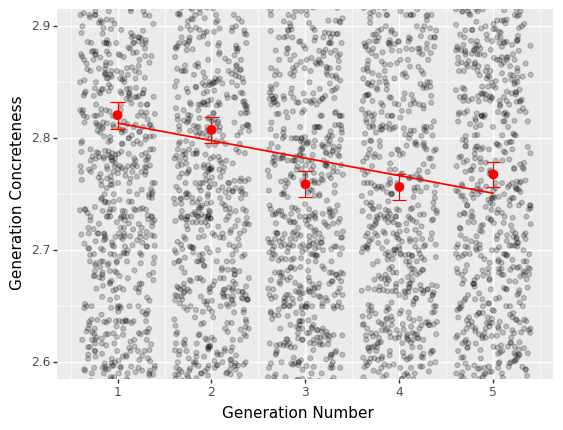

In [ ]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Concreteness"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d2, mapping=aes(x='Generation_Number', y='Generation_Concreteness', ymin=2.7))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.2) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.70, color="red", se=False) + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Concreteness-yerr",ymax="Generation_Concreteness+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Concreteness") +
 plotnine.xlab("Generation Number") + 
  plotnine.coords.coord_cartesian(ylim=(2.6,2.9))
  ).draw()

# **Concreteness vs Semantic Relatedness**

In [ ]:
#bin the generations based on concreteness 
gens = {}
for response, group in generations.groupby("response"):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      score = sum(score)/len(score)
      gens[response] = score

In [ ]:
#bin all of the responses : num bins = 10 
gens = dict(sorted(gens.items(), key=lambda item: item[1]))
len(gens)

7961

In [ ]:
nbins = 100
bins = [[] for j in range(nbins)]
i = 0 
for item in gens:
  if i//int(len(gens)/nbins) < nbins:
    bins[i//int(len(gens)/nbins)].append((item, gens[item]))
  i += 1

In [ ]:
from tqdm import tqdm

In [ ]:
similarity = {}
for b in tqdm(range(len(bins))):
  if b not in similarity: 
    similarity[b] = []
  bin = bins[b]
  embeddings = {}
  for response in bin:
    response = response[0]
    embeddings[response] = model.encode(response)
  for i in range(len(bin)):
    for j in range(i+1, len(bin)):
      similarity[b].append(dist(embeddings[bin[i][0]], embeddings[bin[j][0]]))
  print(b)
similarity 


  1%|          | 1/100 [00:00<01:06,  1.48it/s]

0


  2%|▏         | 2/100 [00:01<01:03,  1.54it/s]

1


  3%|▎         | 3/100 [00:01<01:02,  1.54it/s]

2


  4%|▍         | 4/100 [00:02<01:02,  1.53it/s]

3


  5%|▌         | 5/100 [00:03<01:01,  1.55it/s]

4


  6%|▌         | 6/100 [00:03<01:00,  1.56it/s]

5


  7%|▋         | 7/100 [00:04<01:00,  1.53it/s]

6


  8%|▊         | 8/100 [00:05<00:59,  1.55it/s]

7


  9%|▉         | 9/100 [00:05<00:58,  1.56it/s]

8


 10%|█         | 10/100 [00:06<00:57,  1.57it/s]

9


 11%|█         | 11/100 [00:07<00:56,  1.58it/s]

10


 12%|█▏        | 12/100 [00:07<00:56,  1.57it/s]

11


 13%|█▎        | 13/100 [00:08<00:55,  1.57it/s]

12


 14%|█▍        | 14/100 [00:09<00:55,  1.55it/s]

13


 15%|█▌        | 15/100 [00:09<00:54,  1.55it/s]

14


 16%|█▌        | 16/100 [00:10<00:55,  1.53it/s]

15


 17%|█▋        | 17/100 [00:10<00:53,  1.56it/s]

16


 18%|█▊        | 18/100 [00:11<00:52,  1.56it/s]

17


 19%|█▉        | 19/100 [00:12<00:54,  1.49it/s]

18


 20%|██        | 20/100 [00:13<00:54,  1.47it/s]

19


 21%|██        | 21/100 [00:13<00:53,  1.48it/s]

20


 22%|██▏       | 22/100 [00:14<00:53,  1.45it/s]

21


 23%|██▎       | 23/100 [00:15<00:52,  1.47it/s]

22


 24%|██▍       | 24/100 [00:15<00:51,  1.48it/s]

23


 25%|██▌       | 25/100 [00:16<00:49,  1.50it/s]

24


 26%|██▌       | 26/100 [00:17<00:48,  1.51it/s]

25


 27%|██▋       | 27/100 [00:17<00:47,  1.53it/s]

26


 28%|██▊       | 28/100 [00:18<00:46,  1.54it/s]

27


 29%|██▉       | 29/100 [00:18<00:46,  1.54it/s]

28


 30%|███       | 30/100 [00:19<00:45,  1.53it/s]

29


 31%|███       | 31/100 [00:20<00:45,  1.53it/s]

30


 32%|███▏      | 32/100 [00:20<00:44,  1.54it/s]

31


 33%|███▎      | 33/100 [00:21<00:44,  1.51it/s]

32


 34%|███▍      | 34/100 [00:22<00:43,  1.51it/s]

33


 35%|███▌      | 35/100 [00:22<00:42,  1.53it/s]

34


 36%|███▌      | 36/100 [00:23<00:42,  1.52it/s]

35


 37%|███▋      | 37/100 [00:24<00:41,  1.53it/s]

36


 38%|███▊      | 38/100 [00:24<00:41,  1.51it/s]

37


 39%|███▉      | 39/100 [00:25<00:41,  1.48it/s]

38


 40%|████      | 40/100 [00:26<00:40,  1.49it/s]

39


 41%|████      | 41/100 [00:26<00:38,  1.53it/s]

40


 42%|████▏     | 42/100 [00:27<00:38,  1.49it/s]

41


 43%|████▎     | 43/100 [00:28<00:38,  1.47it/s]

42


 44%|████▍     | 44/100 [00:28<00:38,  1.47it/s]

43


 45%|████▌     | 45/100 [00:29<00:37,  1.47it/s]

44


 46%|████▌     | 46/100 [00:30<00:36,  1.50it/s]

45


 47%|████▋     | 47/100 [00:30<00:34,  1.52it/s]

46


 48%|████▊     | 48/100 [00:31<00:34,  1.50it/s]

47


 49%|████▉     | 49/100 [00:32<00:36,  1.41it/s]

48


 50%|█████     | 50/100 [00:33<00:38,  1.30it/s]

49


 51%|█████     | 51/100 [00:34<00:39,  1.23it/s]

50


 52%|█████▏    | 52/100 [00:35<00:40,  1.19it/s]

51


 53%|█████▎    | 53/100 [00:35<00:37,  1.25it/s]

52


 54%|█████▍    | 54/100 [00:36<00:34,  1.34it/s]

53


 55%|█████▌    | 55/100 [00:37<00:32,  1.37it/s]

54


 56%|█████▌    | 56/100 [00:37<00:30,  1.44it/s]

55


 57%|█████▋    | 57/100 [00:38<00:28,  1.50it/s]

56


 58%|█████▊    | 58/100 [00:39<00:27,  1.53it/s]

57


 59%|█████▉    | 59/100 [00:39<00:26,  1.54it/s]

58


 60%|██████    | 60/100 [00:40<00:25,  1.56it/s]

59


 61%|██████    | 61/100 [00:40<00:24,  1.57it/s]

60


 62%|██████▏   | 62/100 [00:41<00:24,  1.53it/s]

61


 63%|██████▎   | 63/100 [00:42<00:24,  1.50it/s]

62


 64%|██████▍   | 64/100 [00:42<00:23,  1.51it/s]

63


 65%|██████▌   | 65/100 [00:43<00:22,  1.55it/s]

64


 66%|██████▌   | 66/100 [00:44<00:22,  1.53it/s]

65


 67%|██████▋   | 67/100 [00:44<00:21,  1.56it/s]

66


 68%|██████▊   | 68/100 [00:45<00:20,  1.59it/s]

67


 69%|██████▉   | 69/100 [00:46<00:19,  1.61it/s]

68


 70%|███████   | 70/100 [00:46<00:19,  1.56it/s]

69


 71%|███████   | 71/100 [00:47<00:18,  1.58it/s]

70


 72%|███████▏  | 72/100 [00:47<00:17,  1.59it/s]

71


 73%|███████▎  | 73/100 [00:48<00:17,  1.55it/s]

72


 74%|███████▍  | 74/100 [00:49<00:17,  1.52it/s]

73


 75%|███████▌  | 75/100 [00:49<00:16,  1.56it/s]

74


 76%|███████▌  | 76/100 [00:50<00:15,  1.57it/s]

75


 77%|███████▋  | 77/100 [00:51<00:14,  1.55it/s]

76


 78%|███████▊  | 78/100 [00:51<00:13,  1.58it/s]

77


 79%|███████▉  | 79/100 [00:52<00:13,  1.56it/s]

78


 80%|████████  | 80/100 [00:53<00:12,  1.54it/s]

79


 81%|████████  | 81/100 [00:53<00:12,  1.53it/s]

80


 82%|████████▏ | 82/100 [00:54<00:11,  1.53it/s]

81


 83%|████████▎ | 83/100 [00:55<00:11,  1.54it/s]

82


 84%|████████▍ | 84/100 [00:55<00:10,  1.56it/s]

83


 85%|████████▌ | 85/100 [00:56<00:09,  1.56it/s]

84


 86%|████████▌ | 86/100 [00:56<00:08,  1.58it/s]

85


 87%|████████▋ | 87/100 [00:57<00:08,  1.59it/s]

86


 88%|████████▊ | 88/100 [00:58<00:07,  1.55it/s]

87


 89%|████████▉ | 89/100 [00:58<00:07,  1.53it/s]

88


 90%|█████████ | 90/100 [00:59<00:06,  1.51it/s]

89


 91%|█████████ | 91/100 [01:00<00:05,  1.51it/s]

90


 92%|█████████▏| 92/100 [01:00<00:05,  1.50it/s]

91


 93%|█████████▎| 93/100 [01:01<00:04,  1.50it/s]

92


 94%|█████████▍| 94/100 [01:02<00:03,  1.54it/s]

93


 95%|█████████▌| 95/100 [01:02<00:03,  1.52it/s]

94


 96%|█████████▌| 96/100 [01:03<00:02,  1.49it/s]

95


 97%|█████████▋| 97/100 [01:04<00:02,  1.49it/s]

96


 98%|█████████▊| 98/100 [01:04<00:01,  1.51it/s]

97


 99%|█████████▉| 99/100 [01:05<00:00,  1.48it/s]

98


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]

99


{0: [0.9490207396447659,
  0.5794934332370758,
  1.035237193107605,
  0.895052433013916,
  0.7976781576871872,
  0.9088674634695053,
  0.807510107755661,
  0.8787613362073898,
  0.8456679284572601,
  0.9593059048056602,
  0.9039416089653969,
  0.7362322509288788,
  0.8226848244667053,
  0.843797117471695,
  0.8152720481157303,
  0.8927489817142487,
  0.8476486057043076,
  0.8870234861969948,
  0.9415591508150101,
  0.9415591508150101,
  0.849584624171257,
  0.849584624171257,
  0.8972637504339218,
  0.7829173803329468,
  0.8886111825704575,
  0.7522614300251007,
  0.8254474848508835,
  0.8840466663241386,
  0.9814377836883068,
  0.9171071574091911,
  0.8883391171693802,
  0.9816843699663877,
  0.8624863177537918,
  0.6486408412456512,
  0.7940337508916855,
  0.9500325657427311,
  0.8236911743879318,
  0.7173047363758087,
  0.6897094547748566,
  0.8193351030349731,
  0.7719591408967972,
  0.9552476555109024,
  0.9136991947889328,
  0.9563990272581577,
  0.8137679994106293,
  0.642281919

In [ ]:
buckets = {}
for key in similarity:
  buckets[key] = sum(similarity[key])/len(similarity[key])

In [ ]:
x_avg = []
y_avg = []

for key in buckets:
  x_avg.append(key)
  y_avg.append(buckets[key])

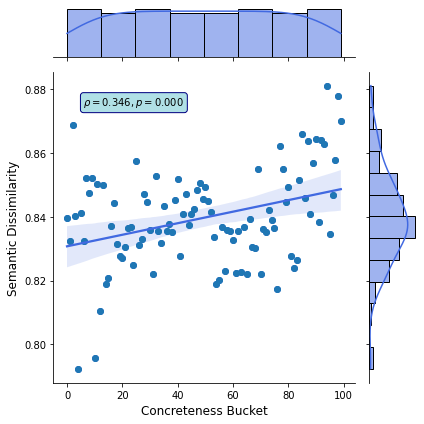

In [ ]:
# to be clear, higher buckets have higher concreteness. 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Concreteness Bucket', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

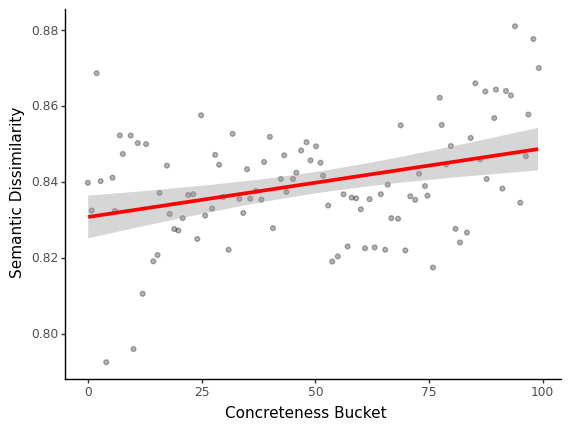

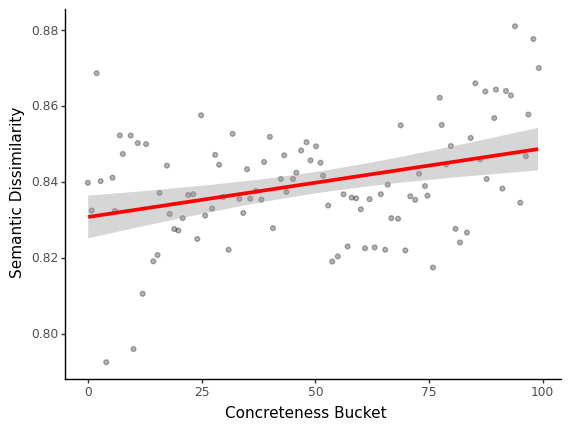

In [ ]:
d = pd.DataFrame(data=[x_avg,y_avg])
d = d.T
d.columns = ["Concreteness_Bucket", "Semantic_Dissimilarity"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Concreteness_Bucket', y='Semantic_Dissimilarity'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Concreteness Bucket") +
 plotnine.ylab("Semantic Dissimilarity") + 
 plotnine.theme_classic()
).draw()

#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


# **Semantic Exploration vs Average Concreteness**

In [ ]:
# semantic exploration 
exploration = {}
for id, group in generations.groupby("id"):
  exploration[id] = 0
  len_responses = 0
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[id] += dist(embeddings[i], embeddings[j])
  exploration[id] /= len_responses

In [ ]:
#determine avg concreteness 
id_concreteness = {}
for id, group in generations.groupby("id"):
  for response, group2 in group.groupby("response"):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      if id not in id_concreteness:
        id_concreteness[id] = []
      score = sum(score)/len(score)
      id_concreteness[id].append(score)

In [ ]:
for id in id_concreteness:
  id_concreteness[id] = sum(id_concreteness[id])/len(id_concreteness[id])

In [ ]:
x = []
y = []
for id in id_concreteness:
  if id in exploration:
    x.append(id_concreteness[id])
    y.append(exploration[id])

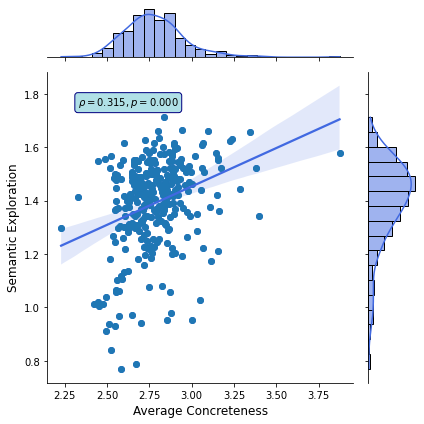

In [ ]:
#display adjusted exploration vs average sentiment 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Concreteness', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

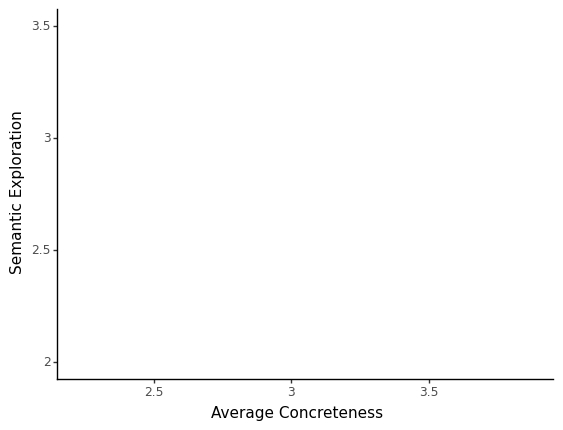

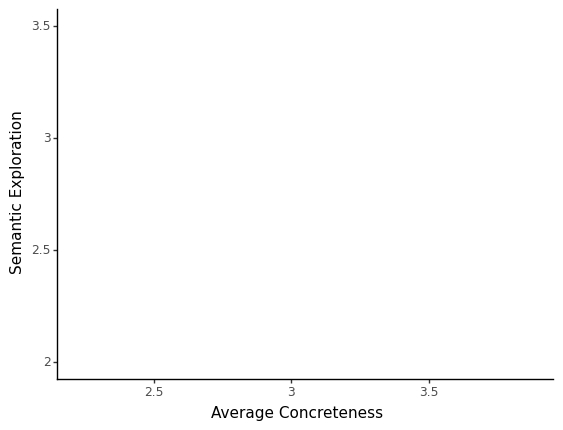

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Average_Concreteness", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Average_Concreteness', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Average Concreteness") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.theme_classic() + 
 plotnine.coords.coord_cartesian(ylim=(2,3.5))
).draw()

#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


# **Generation Concreteness vs Subjective Score**

In [ ]:
concreteness = []
subjective = []
for response, group in generations.groupby("response"):
  response = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(response.split(" "))
  for word in response.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0 :
    score = sum(score)/len(score)
    concreteness.append(score)
    subjective.append(list(group["reflection_score"])[0])


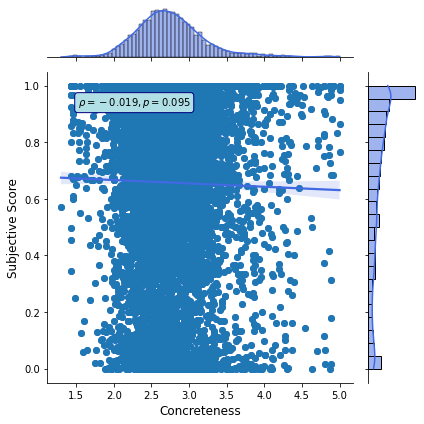

In [ ]:
x = concreteness
y = subjective

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Concreteness', ylabel='Subjective Score', size=12)
plt.tight_layout()
plt.show()

# **Generation Concreteness vs Generation Sentiment**

In [ ]:
concreteness = []
sentiment = []
for response, group in generations.groupby("response"):
  response = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(response.split(" "))
  for word in response.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0:
    score = sum(score)/len(score)
    concreteness.append(score)
    sentiment.append(predict_sentiment(response))


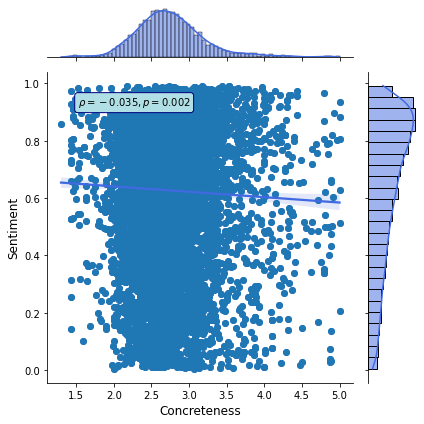

In [ ]:
x = concreteness
y = sentiment

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Concreteness', ylabel='Sentiment', size=12)
plt.tight_layout()
plt.show()

# Heatmap Analysis 
* The goal here is twofold: 
1. Density map of generations per gen_num in 2D PCA space
    * Maybe make this like 100 by 100
2. Heatmap of average senitment per gen_num in 2D PCA space

Then, perhaps we can overlay these two figures.

## Density Map

In [14]:
generations

Unnamed: 0  vignette_name  generation_number  \
0              0              1                  1   
1              1              1                  2   
2              2              1                  3   
3              3              1                  4   
4              4              1                  5   
...          ...            ...                ...   
9315        9315             18                  1   
9316        9316             18                  2   
9317        9317             18                  3   
9318        9318             18                  4   
9319        9319             18                  5   

                                               response  reflection_score   id  
0                         Ask family/friends for money.          0.850000    1  
1                    Try and find it cheaper elsewhere.          0.803333    1  
2                                      Take out a loan.          0.473333    1  
3                                       Pay it anyways.          0.776667    1  
4              Try and haggle with insurance or seller.          0.583333    1  
...                                                 ...               ...  ...  
9315               keep going and ignore the competitor          0.413333  311  
9316                          stop and try to help them          0.890000  311  
9317  find a way to send a message to people that so...          0.830000  311  
9318     stop and also try and get other people to stop          0.576667  311  
9319  let people know at the next check point what w...          0.943333  311  

[9320 rows x 6 columns]

In [15]:
generations["vignette_name"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])

In [76]:
from tqdm import tqdm 
#start witht just the first generation embeddings
names = set([1,  2,  3,  4,  5,  6])
embeddings = []
embed_map = {} #map index in embeddings to the pnum 
embed_weights = [] #keep the sentiment of embeddings[i]
responses = []
vigns = []
for pnum, group in tqdm(generations.groupby("generation_number")):
    for row in tqdm(list(zip(group["response"],group["vignette_name"]))):
        response = row[0]
        name = row[1]
        if not pd.isna(response) and name in names:
            embeddings.append(model.encode(response))
            responses.append(response)
            vigns.append(name)
            embed_map[len(embeddings)-1] = pnum
            embed_weights.append(predict_sentiment(response))

  0%|                                                                                                                                                                              | 0/1865 [00:00<?, ?it/s]/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/option-generation/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.


 31%|███████████████████████████████████████████████████▌                                                                                                                | 586/1865 [00:08<00:18, 69.93it/s]


 31%|██████████████████████████████████████████████████▊                                                                                                                 | 576/1861 [00:07<00:17, 71.59it/s]


 30%|█████████████████████████████████████████████████▊                                                                                                                  | 566/1865 [00:07<00:18, 71.69it/s]


 30%|████████████████████████████████████████████████▌                                                                                                                   | 552/1864 [00:07<00:17, 73.83it/s]


 29%|███████████████████████████████████████████████▊                                                                                                                    | 544/1865 [00:07<00:18, 71.63it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.67s/it]


In [77]:
len(embeddings)

3118

In [78]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import binned_statistic_2d
from sklearn.manifold import TSNE

In [79]:
embeddings = StandardScaler().fit_transform(embeddings)
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=10)

In [80]:
#get all of the embeddings for possibilities 1,2 and 3

embed_1 = []
embed_1_weights = []
embed_1_responses = []
for i in range(len(embeddings)):
    if embed_map[i] == 1:
        embed_1.append(embeddings[i])
        embed_1_weights.append(embed_weights[i])
        embed_1_responses.append(str(str(vigns[i]) +": " +responses[i]))

        
embed_2 = []
embed_2_weights = []
embed_2_responses = []
for i in range(len(embeddings)):
    if embed_map[i] == 2:
        embed_2.append(embeddings[i])
        embed_2_weights.append(embed_weights[i])
        embed_2_responses.append(str(str(vigns[i]) +": " +responses[i]))
        

embed_3 = []
embed_3_weights = []
embed_3_responses = []
for i in range(len(embeddings)):
    if embed_map[i] == 3:
        embed_3.append(embeddings[i])
        embed_3_weights.append(embed_weights[i])
        embed_3_responses.append(str(str(vigns[i]) +": " +responses[i]))
        
embed_4 = []
embed_4_weights = []
embed_4_responses = []
for i in range(len(embeddings)):
    if embed_map[i] == 4:
        embed_4.append(embeddings[i])
        embed_4_weights.append(embed_weights[i])
        embed_4_responses.append(str(str(vigns[i]) +": " +responses[i]))

embed_5 = []
embed_5_weights = []
embed_5_responses = []
for i in range(len(embeddings)):
    if embed_map[i] == 5:
        embed_5.append(embeddings[i])
        embed_5_weights.append(embed_weights[i])
        embed_5_responses.append(str(str(vigns[i]) +": " +responses[i]))



In [81]:
print(len(embed_1), len(embed_5))

624 624


In [82]:
bin_size = 50

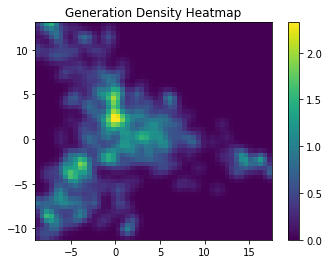

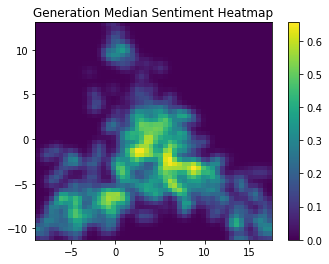

In [83]:
#scatterplot
principalComponents = pca.fit_transform(np.array(embed_1))
embed_1 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
embed_1["responses"] = embed_1_responses
fig = px.scatter(embed_1, x="pc1", y="pc2", opacity=.4, hover_name="responses")
fig.show()

#heatmap
heatmap1, xedges, yedges = np.histogram2d(list(embed_1["pc1"]), list(embed_1["pc2"]), bins=bin_size, density=False)
heatmap1 = gaussian_filter(heatmap1, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap1.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights as sentiment
# heatmap, xedges, yedges = np.histogram2d(list(embed_1["pc1"]), list(embed_1["pc2"]), bins=bin_size, weights = embed_1_weights, density=True)
# # average = heatmap / np.sum(heatmap)
# heatmap = gaussian_filter(heatmap, sigma=1)
# # print(heatmap)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()

#median sentiment heatmap

# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_1["pc1"]), list(embed_1["pc2"]), embed_1_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()


In [84]:
# from scipy.stats import binned_statistic_2d

# # Compute the median of the weights in each bin
# median, _, _, _ = binned_statistic_2d(list(embed_1["pc1"]), list(embed_1["pc2"]), embed_1_weights, statistic='median', bins=(bin_size, bin_size))
# #set all nans to 0
# for y in range(len(median)): 
#     for x in range(len(median[y])):
#         if pd.isna(median[x][y]):
#             median[x][y]  = 0
# # median = gaussian_filter(median, sigma=2)

# # plot the heatmap
# plt.clf()
# plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
# plt.colorbar()
# plt.show()

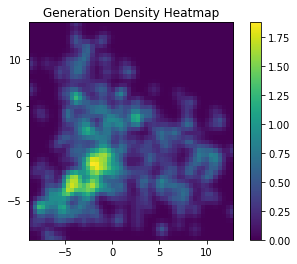

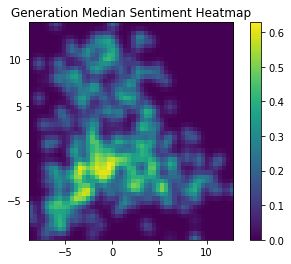

In [85]:
#scatterplot
principalComponents = pca.fit_transform(np.array(embed_2))
embed_2 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
embed_2["responses"] = embed_2_responses
fig = px.scatter(embed_1, x="pc1", y="pc2", opacity=.4, hover_name="responses")
fig.show()

#heatmap with raw numbers 
heatmap2, xedges, yedges = np.histogram2d(list(embed_2["pc1"]), list(embed_2["pc2"]), bins=bin_size, density=False)
heatmap2 = gaussian_filter(heatmap2, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap2.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights
# heatmap, xedges, yedges = np.histogram2d(list(embed_2["pc1"]), list(embed_2["pc2"]), bins=bin_size, weights = embed_2_weights, density=True)
# # average = heatmap / np.sum(heatmap)
# heatmap = gaussian_filter(heatmap, sigma=1)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()


#median sentiment heatmap
# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_2["pc1"]), list(embed_2["pc2"]), embed_2_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()

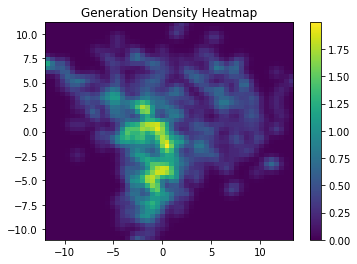

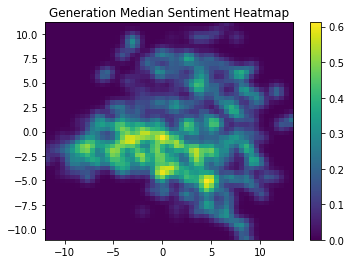

In [86]:
#scatterplot
principalComponents = pca.fit_transform(np.array(embed_3))
embed_3 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
embed_3["responses"] = embed_3_responses
fig = px.scatter(embed_1, x="pc1", y="pc2", opacity=.4, hover_name="responses")
fig.show()

#heatmap with raw numbers
heatmap3, xedges, yedges = np.histogram2d(list(embed_3["pc1"]), list(embed_3["pc2"]), bins=bin_size)
heatmap3 = gaussian_filter(heatmap3, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap3.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights
# heatmap, xedges, yedges = np.histogram2d(list(embed_3["pc1"]), list(embed_3["pc2"]), bins=bin_size, weights = embed_3_weights, density=False)
# heatmap = gaussian_filter(heatmap, sigma=1)
# # print(heatmap)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()

#median sentiment heatmap
# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_3["pc1"]), list(embed_3["pc2"]), embed_3_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()


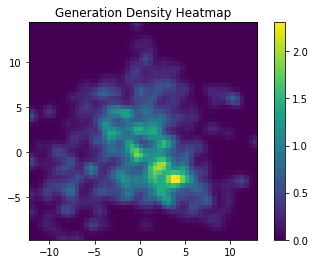

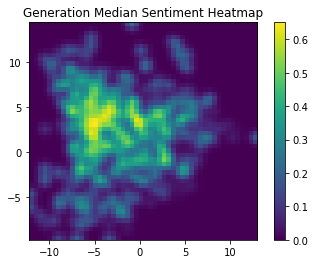

In [87]:
#scatterplot
principalComponents = pca.fit_transform(np.array(embed_4))
embed_4 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
embed_4["responses"] = embed_4_responses
fig = px.scatter(embed_4, x="pc1", y="pc2", opacity=.4, hover_name="responses")
fig.show()

#heatmap with raw numbers
heatmap4, xedges, yedges = np.histogram2d(list(embed_4["pc1"]), list(embed_4["pc2"]), bins=bin_size)
heatmap4 = gaussian_filter(heatmap4, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap4.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights
# heatmap, xedges, yedges = np.histogram2d(list(embed_4["pc1"]), list(embed_4["pc2"]), bins=bin_size, weights = embed_4_weights, density=False)
# heatmap = gaussian_filter(heatmap, sigma=1)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()

#median sentiment heatmap
# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_4["pc1"]), list(embed_4["pc2"]), embed_4_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()

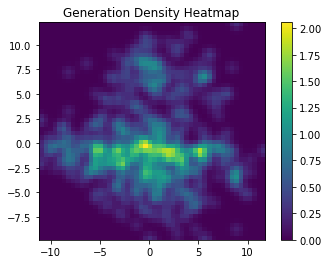

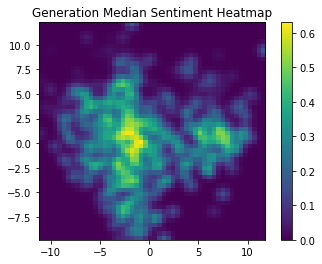

In [88]:
#scatterplot
principalComponents = pca.fit_transform(np.array(embed_5))
embed_5 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
embed_5["responses"] = embed_5_responses
fig = px.scatter(embed_5, x="pc1", y="pc2", opacity=.4, hover_name="responses")
fig.show()

#heatmap
heatmap5, xedges, yedges = np.histogram2d(list(embed_5["pc1"]), list(embed_5["pc2"]), bins=bin_size)
heatmap5 = gaussian_filter(heatmap5, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap5.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights
# heatmap, xedges, yedges = np.histogram2d(list(embed_5["pc1"]), list(embed_5["pc2"]), bins=bin_size, weights = embed_5_weights, density=False)
# heatmap = gaussian_filter(heatmap, sigma=1)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()

#median sentiment heatmap
# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_5["pc1"]), list(embed_5["pc2"]), embed_5_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()

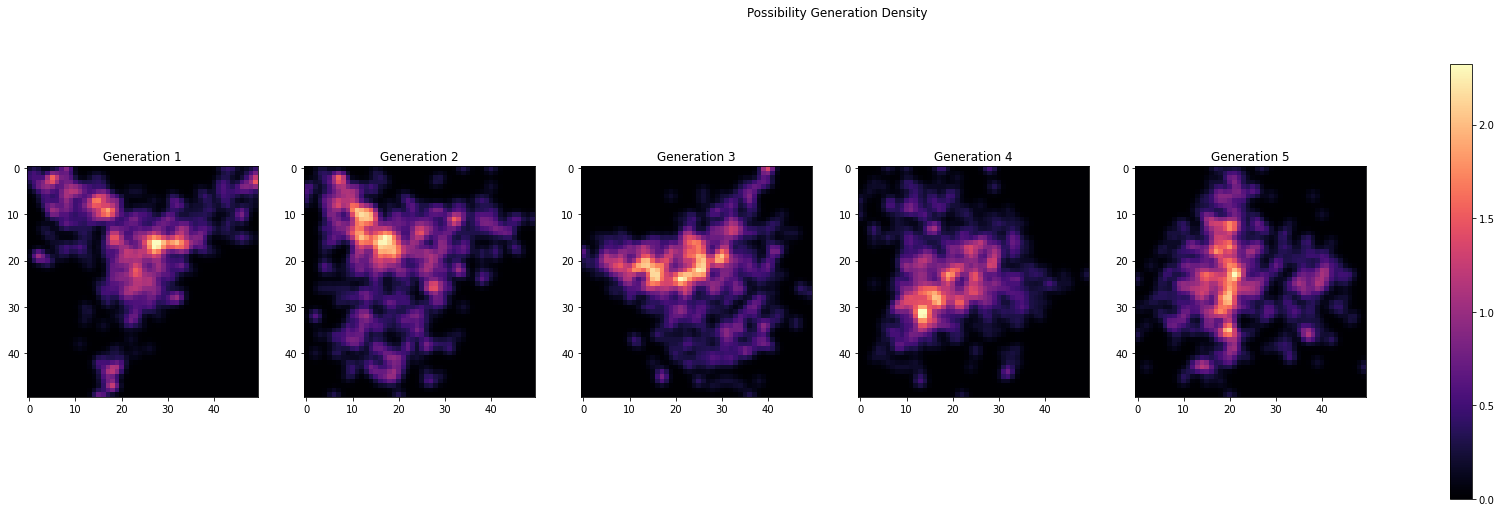

In [89]:
fig, axs = plt.subplots(1, 5, figsize=(30, 8))
# Create some data for the heatmaps

#r,c
# Create the heatmaps
im1 = axs[0].imshow(heatmap1, cmap='magma')
im2 = axs[1].imshow(heatmap2, cmap='magma')
im3 = axs[2].imshow(heatmap3, cmap='magma')
im4 = axs[3].imshow(heatmap4, cmap='magma')
im5 = axs[4].imshow(heatmap5, cmap='magma')

cbar = fig.colorbar(im1, ax=axs)

#Add titles 
fig.suptitle("Possibility Generation Density")
axs[0].set_title("Generation 1")
axs[1].set_title("Generation 2")
axs[2].set_title("Generation 3")
axs[3].set_title("Generation 4")
axs[4].set_title("Generation 5")


# Adjust the layout
# fig.tight_layout()
plt.show()
